In [88]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, gc
from scipy import stats; from scipy.stats import zscore, norm, randint
import warnings; warnings.filterwarnings('ignore')
from rdkit.Chem import rdMolDescriptors, MolFromSmiles, rdmolfiles, rdmolops
from rdkit import DataStructs


In [ ]:
## Import Data and Overview 

In [89]:
data = pd.read_csv("D:\ROSALIND_problems\Servier_test\dataset_single.csv")
data.head()

,P1,mol_id,smiles
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


In [82]:
data.columns , data.shape , data.ndim

(Index(['P1', 'mol_id', 'smiles'], dtype='object'), (4999, 3), 2)

In [83]:
data.info() , data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   P1      4999 non-null   int64 
 1   mol_id  4999 non-null   object
 2   smiles  4999 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


(None,
    P1      mol_id                                             smiles
 0   1  CID2999678    Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
 1   0  CID2999679                Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
 2   1  CID2999672  COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
 3   0  CID5390002  O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
 4   1  CID2999670                          NC(=O)NC(Cc1ccccc1)C(=O)O)

In [38]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
P1,4999.0,0.821764,0.382749,0.0,1.0,1.0,1.0,1.0


## Handling Missing values

In [20]:
print(len(data.mol_id.unique()))

4999


In [57]:

columns = list(['mol_id','P1','smiles'])

print('Descriptive Stats before imputation for columns IF missing values: \n', '--'*35)
display(data[columns].describe().T)

Descriptive Stats before imputation for columns IF missing values: 
 ----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
P1,4999.0,0.821764,0.382749,0.0,1.0,1.0,1.0,1.0


## Univariate Analysis

In [58]:
# Functions that will help us with EDA plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'{col} with outliers')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'{col} without outliers')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

P1 column --------------------------------------------------------------------------------
no of records with outliers values: 891


,P1,mol_id,smiles
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
8,0,CID2999674,CCCc1cc(=O)nc(SCC(=O)N(CC(C)C)C2CCS(=O)(=O)C2)...
9,0,CID2999675,CCn1cnc2c1c(=O)n(CC(=O)Nc1cc(C)on1)c(=O)n2Cc1c...
15,0,CID647480,Cc1nn(-c2ccccc2)c(Cl)c1C1C(C#N)=C(N)OC2=C1C(=O...


EDA for P1 column --------------------------------------------------------------------------------


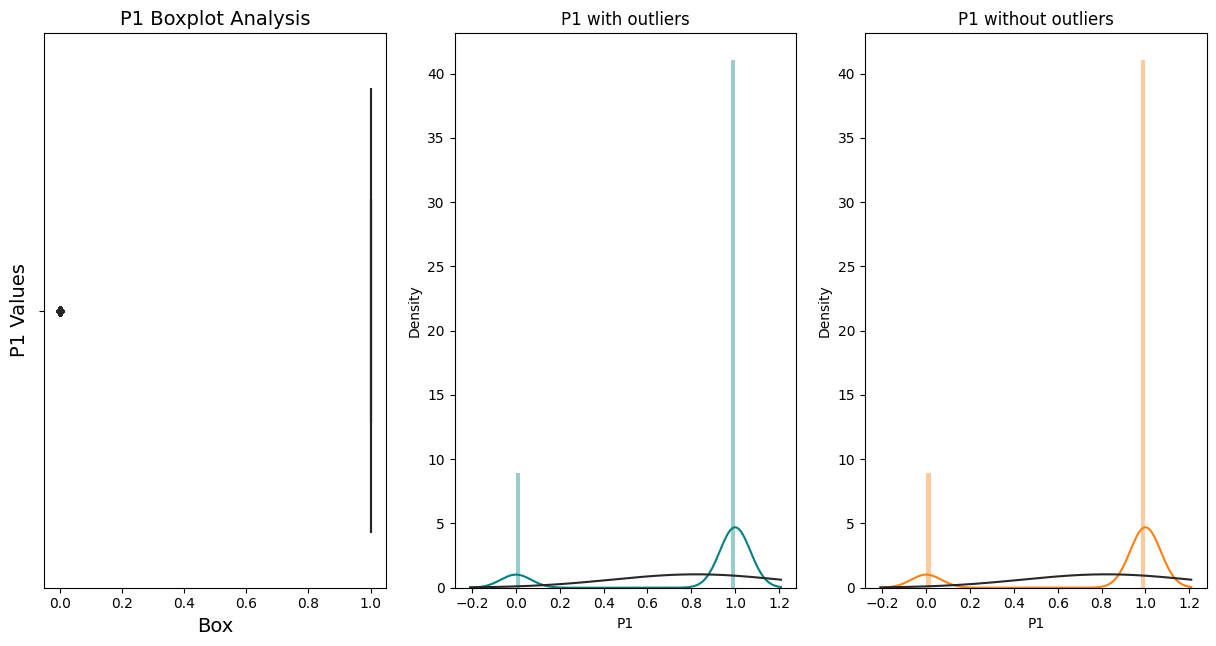

In [67]:
# Outlier, distribution for columns with outliers
boxplotcolumns = ['P1']
for cols in boxplotcolumns:
    Q3 = data[cols].quantile(0.75)
    Q1 = data[cols].quantile(0.25)
    IQR = Q3 - Q1

    print(f'{cols.capitalize()} column', '--'*40)
    count = len(data.loc[(data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR))])
    print(f'no of records with outliers values: {count}')
    
    display(data.loc[(data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR))].head())
    print(f'EDA for {cols.capitalize()} column', '--'*40)
    odp_plots(data, cols)

del cols, IQR, boxplotcolumns

## Transform smiles molecule into morgan vector fingerprint

In [84]:
def computeMorganFP(smile_string, radius=2, size=2048):
    x = np.zeros(size)
    mol = MolFromSmiles(smile_string)
    new_order = rdmolfiles.CanonicalRankAtoms(mol)
    mol = rdmolops.RenumberAtoms(mol, new_order)
    morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius,
                                                            nBits=size,
                                                            useChirality=True,
                                                            useBondTypes=True,
                                                            useFeatures=False
                                                            )
    DataStructs.ConvertToNumpyArray(morgan,x)

    return x


In [90]:
data.drop_duplicates()
data['Morgan_fingerprint'] = data['smiles'].map(computeMorganFP)   # get morganFingerprint as binary array
data.dropna(inplace=True)
df = data.Morgan_fingerprint.apply(pd.Series)  # get df columns for each bit morgan
label = data['P1']  # get label

In [92]:
print(df.head())
print(label.head())

   0     1     2     3     4     5     6     7     8     9     ...  2038  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   2039  2040  2041  2042  2043  2044  2045  2046  2047  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 2048 columns]
0    1
1    0
2    1
3    0
4    1
Name: P1, dtype: int64
